In [117]:
import pandas as pd

# Load the cleaned dataset
file_path = "cleaned_CIC_IDS2017.csv"
df = pd.read_csv(file_path)

# Display dataset info and first few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522009 entries, 0 to 2522008
Data columns (total 39 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Fwd IAT Total             int64  
 1   FIN Flag Count            int64  
 2   Flow Bytes/s              float64
 3    Packet Length Mean       float64
 4    Flow IAT Min             int64  
 5   Idle Mean                 float64
 6    Init_Win_bytes_backward  int64  
 7    act_data_pkt_fwd         int64  
 8    Total Fwd Packets        int64  
 9    Fwd IAT Min              int64  
 10   Fwd IAT Mean             float64
 11   min_seg_size_forward     int64  
 12   Active Min               int64  
 13   Bwd IAT Max              int64  
 14  Fwd PSH Flags             int64  
 15   Bwd IAT Std              float64
 16   PSH Flag Count           int64  
 17   Down/Up Ratio            int64  
 18   Subflow Fwd Bytes        int64  
 19   Active Max               int64  
 20   Bwd Packet Length Min  

In [118]:
df.columns = df.columns.str.strip()  # Apply this at the start


In [119]:
print(df["Label"].unique())  # Should print [0, 1]


[0 1]


In [120]:
print("Class distribution before outlier removal:\n", df["Label"].value_counts())


Class distribution before outlier removal:
 Label
0    2096134
1     425875
Name: count, dtype: int64


In [121]:
# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()


In [122]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Check class distribution
print("\nClass distribution:\n", df["Label"].value_counts())


Dataset shape: (2522009, 39)
Missing values per column:
 Series([], dtype: int64)

Class distribution:
 Label
0    2096134
1     425875
Name: count, dtype: int64


In [123]:
negative_counts = (df < 0).sum()
negative_counts = negative_counts[negative_counts > 0]  # Keep only columns with negative values
print("Columns with negative values and their count:\n", negative_counts)


Columns with negative values and their count:
 Flow Bytes/s                    78
Flow IAT Min                  2880
Init_Win_bytes_backward    1216166
Fwd IAT Min                     17
min_seg_size_forward            35
Fwd Header Length.1             35
Flow Packets/s                 107
Bwd Header Length               22
Init_Win_bytes_forward      911027
dtype: int64


In [124]:
# List of columns where negatives should be replaced with 0
replace_with_zero = [
    'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'min_seg_size_forward', 
    'Fwd Header Length.1', 'Bwd Header Length'
]

# List of columns where negatives should be replaced with median
replace_with_median = [
    'Flow Bytes/s', 'Flow IAT Min', 'Fwd IAT Min', 'Flow Packets/s'
]

# Replace negative values with 0
df[replace_with_zero] = df[replace_with_zero].clip(lower=0)

# Replace negative values with median
for col in replace_with_median:
    median_value = df[col].median()
    df[col] = df[col].apply(lambda x: median_value if x < 0 else x)


In [125]:
print(df["Label"].unique())  # Should print [0, 1]
print("Class distribution before outlier removal:\n", df["Label"].value_counts())


[0 1]
Class distribution before outlier removal:
 Label
0    2096134
1     425875
Name: count, dtype: int64


In [126]:
negative_counts = (df < 0).sum()
negative_counts = negative_counts[negative_counts > 0]  # Keep only columns with negative values
print("Columns with negative values and their count:\n", negative_counts)


Columns with negative values and their count:
 Series([], dtype: int64)


<Figure size 1500x1200 with 0 Axes>

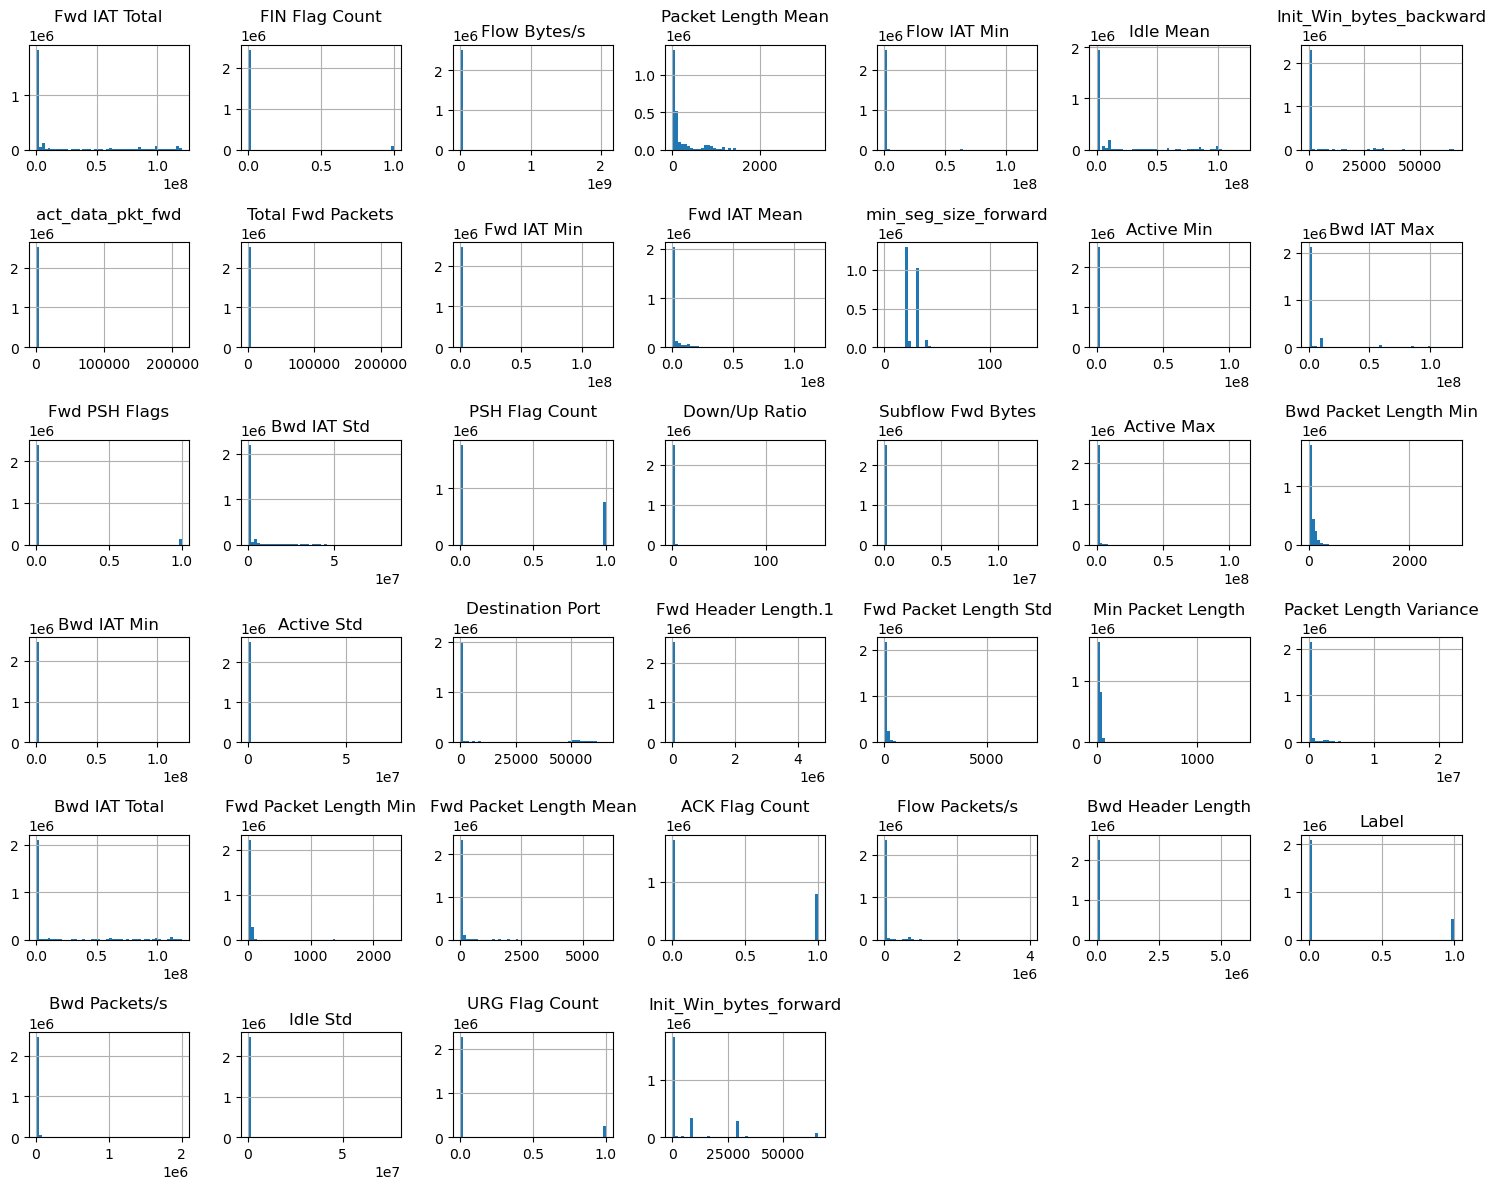

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric features
numeric_features = df.select_dtypes(include=[np.number])

# Plot histograms
plt.figure(figsize=(15, 12))
numeric_features.hist(bins=50, figsize=(15, 12), layout=(6, 7))  # Adjust rows/cols based on # of features
plt.tight_layout()
plt.show()


In [128]:
# Compute skewness of each feature
skewness = numeric_features.skew().sort_values(ascending=False)
print(skewness)


Subflow Fwd Bytes          758.901185
act_data_pkt_fwd           268.628078
Total Fwd Packets          230.670174
Fwd Header Length.1        229.854982
Bwd Header Length          229.812976
Flow Bytes/s                45.688300
Active Min                  45.058170
Active Std                  38.241663
Flow IAT Min                23.487425
Active Max                  23.028467
Bwd Packets/s               21.711695
Fwd Packet Length Min       19.336949
Down/Up Ratio               12.571014
Min Packet Length           10.550871
Fwd Packet Length Std        9.966545
Idle Std                     9.888652
Bwd IAT Min                  9.350358
Fwd IAT Min                  9.210994
Fwd Packet Length Mean       8.686013
Flow Packets/s               7.023123
Fwd IAT Mean                 6.698047
Bwd IAT Std                  5.443669
FIN Flag Count               5.304893
Packet Length Variance       5.073641
Init_Win_bytes_backward      4.929203
Bwd Packet Length Min        4.786761
Fwd PSH Flag

In [129]:
print("Original shape:", df.shape)

Original shape: (2522009, 39)


In [130]:
# Compute IQR only on normal traffic (Label = 0)
Q1 = df[df["Label"] == 0][numeric_features.columns].quantile(0.25)
Q3 = df[df["Label"] == 0][numeric_features.columns].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply IQR filtering only to normal traffic
mask_normal = (df[df["Label"] == 0][numeric_features.columns] >= lower_bound) & \
              (df[df["Label"] == 0][numeric_features.columns] <= upper_bound)

df_filtered = pd.concat([df[df["Label"] == 1],  # Keep all attack traffic
                         df[df["Label"] == 0][mask_normal.all(axis=1)]])  # Filter normal traffic

print("Class distribution after outlier removal:\n", df_filtered["Label"].value_counts())


Class distribution after outlier removal:
 Label
1    425875
0    317980
Name: count, dtype: int64


<Figure size 1500x1200 with 0 Axes>

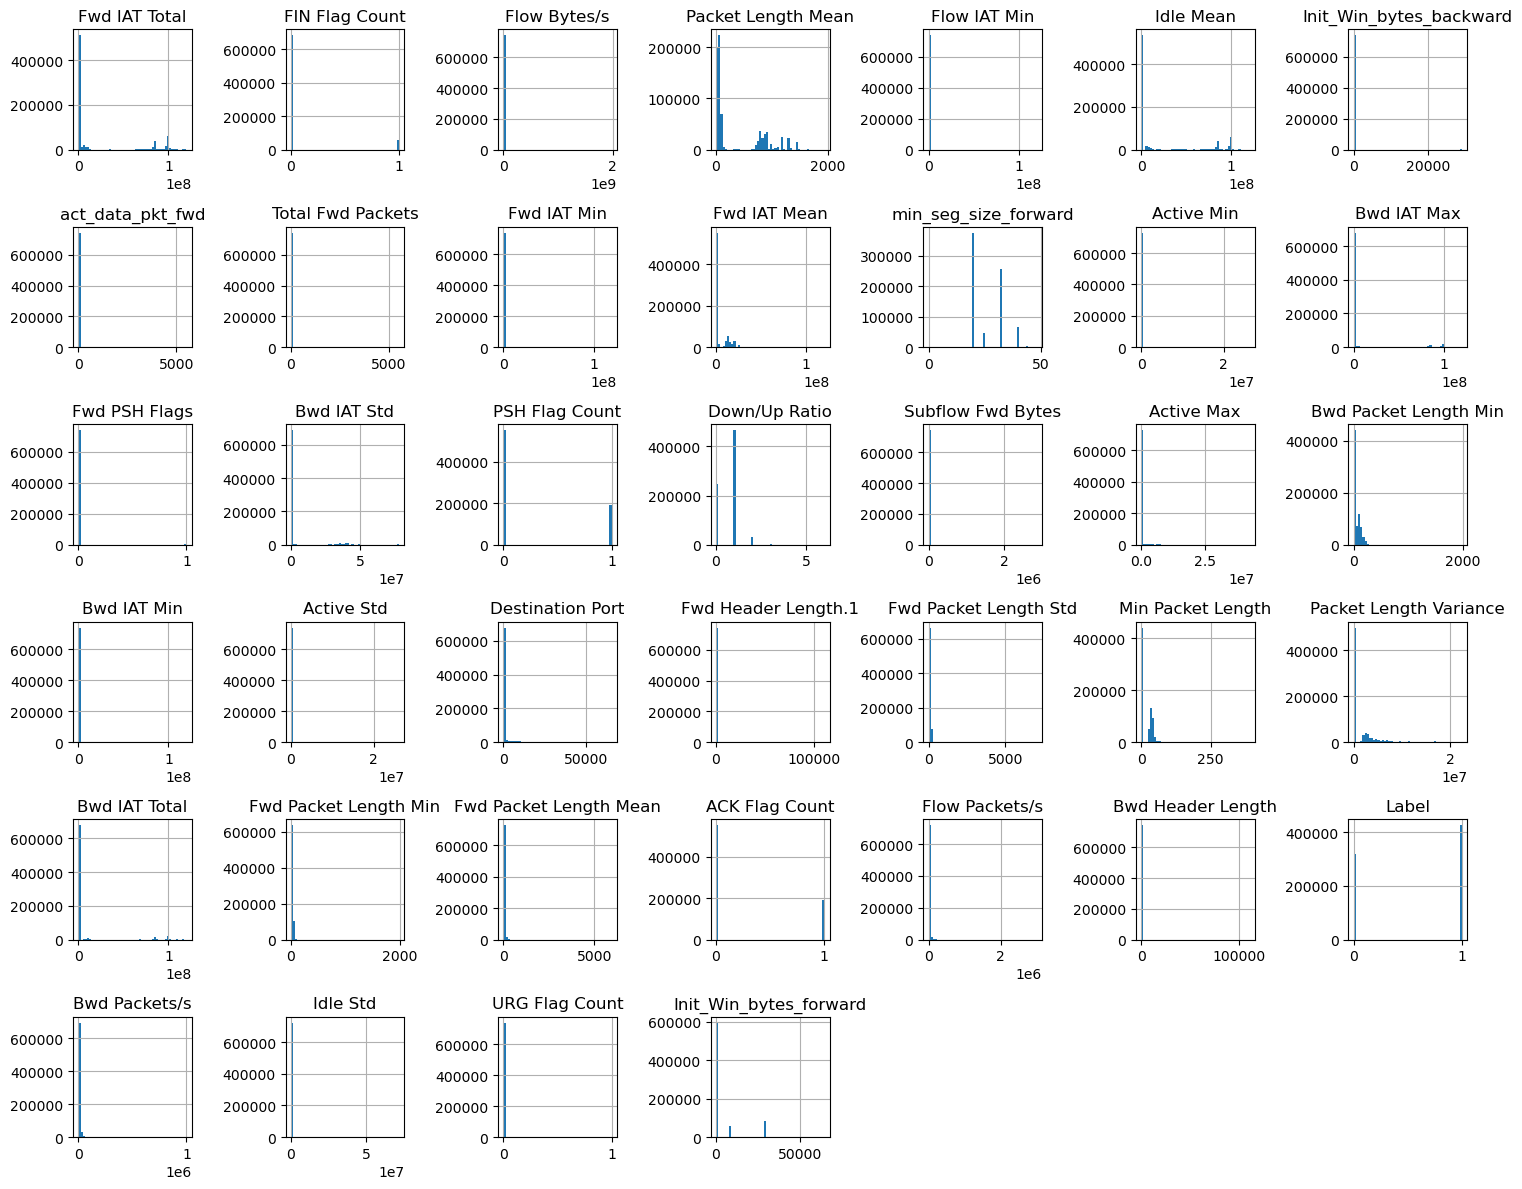

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric features from the filtered dataset
numeric_features_filtered = df_filtered.select_dtypes(include=[np.number])

# Plot histograms for the cleaned data
plt.figure(figsize=(15, 12))
numeric_features_filtered.hist(bins=50, figsize=(15, 12), layout=(6, 7))  # Adjust rows/cols based on features
plt.tight_layout()
plt.show()


In [132]:
# Find columns with negative values and their count in the cleaned dataset
negative_values_filtered = (df_filtered < 0).sum()
negative_columns_filtered = negative_values_filtered[negative_values_filtered > 0]

# Display columns with negative values and their count
print("Columns with negative values and their count (after outlier removal):")
print(negative_columns_filtered)


Columns with negative values and their count (after outlier removal):
Series([], dtype: int64)


DATA SCALING

In [133]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Selecting only feature columns (excluding the label column)
feature_columns = df_filtered.columns.difference(['Label'])

# Applying StandardScaler
df_filtered[feature_columns] = scaler.fit_transform(df_filtered[feature_columns])

# Verifying the transformation
print(df_filtered.head())  # Display first few rows
print(df_filtered.describe())  # Check if mean is ~0 and std is ~1


       Fwd IAT Total  FIN Flag Count  Flow Bytes/s  Packet Length Mean  \
18597      -0.562980       -0.293329     -0.020213            1.567325   
18598      -0.448864       -0.293329     -0.023276           -0.751785   
18599      -0.562664       -0.293329     -0.019621            1.799236   
18600       1.468604       -0.293329     -0.023228            1.213592   
18601      -0.562979       -0.293329     -0.017109            1.800559   

       Flow IAT Min  Idle Mean  Init_Win_bytes_backward  act_data_pkt_fwd  \
18597     -0.050169  -0.543552                 0.003780          0.020864   
18598     -0.050067  -0.543552                -0.111527          0.104252   
18599     -0.050157  -0.543552                 0.003780          0.020864   
18600     -0.050168   0.514002                 0.003780          0.354416   
18601     -0.050169  -0.543552                 0.003780          0.020864   

       Total Fwd Packets  Fwd IAT Min  ...  Fwd Packet Length Min  \
18597          -0.05076

HYBRID FEATURE SELECTION

In [134]:
from sklearn.feature_selection import VarianceThreshold

# Drop the target column
X_filtered = df_filtered.drop(columns=["Label"])

# Apply VarianceThreshold (removing features with variance below 0.01)
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X_filtered)

# Get selected feature names
selected_features_var = X_filtered.columns[var_thresh.get_support()]
print("Features retained after Variance Threshold:", len(selected_features_var))

# Convert back to DataFrame
df_filtered_var = pd.DataFrame(X_var, columns=selected_features_var)

# Add back the Label column
df_filtered_var["Label"] = df_filtered["Label"].values

print(f"Dataset shape after variance thresholding: {df_filtered_var.shape}")


Features retained after Variance Threshold: 38
Dataset shape after variance thresholding: (743855, 39)


In [135]:
import pandas as pd
import numpy as np

# Convert transformed data back to DataFrame
X_var_df = pd.DataFrame(X_var, columns=selected_features_var)

# Compute correlation matrix
corr_matrix = X_var_df.corr().abs()

# Find highly correlated features (correlation > 0.9)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Drop highly correlated features
X_corr = X_var_df.drop(columns=high_corr_features)

print("Features retained after Correlation Analysis:", len(X_corr.columns))

# Convert back to DataFrame with Label column
df_final = X_corr.copy()
df_final["Label"] = df_filtered_var["Label"].values

print(f"Dataset shape after correlation filtering: {df_final.shape}")


Features retained after Correlation Analysis: 31
Dataset shape after correlation filtering: (743855, 32)


In [136]:
from imblearn.over_sampling import SMOTE

# Extract features and labels from df_final (not df_filtered_var)
X_final = df_final.drop(columns=["Label"])  # Features after all filtering
y_final = df_final["Label"]  # Labels

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y_final)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X_final.columns)
df_balanced["Label"] = y_resampled  # Add back the label column

# Verify class distribution after SMOTE
print("Class distribution after SMOTE:\n", df_balanced["Label"].value_counts())


Class distribution after SMOTE:
 Label
1    425875
0    425875
Name: count, dtype: int64
